<a href="https://colab.research.google.com/github/Marwa-Chouhdary/Data-Science-Projects/blob/main/Sales_Forecasting_for_a_Retail_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecasting for a Retail Chain

In [1]:
!pip install prophet

In [2]:
from prophet import Prophet

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

##Load Dataset

In [26]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

#Merge Datasets

In [27]:
df = pd.merge(sales, features, on=["Store", "Date", "IsHoliday"], how="left")
df = pd.merge(df, stores, on="Store", how="left")

#Clean Data

In [29]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

#Check for missing values, duplicates, outliers

In [32]:
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outliers = (np.abs(df[numeric_cols].apply(zscore)) > 3).sum()
print("\nOutliers per column:\n", outliers)

Missing Values:
 Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

Duplicate Rows: 0

Outliers per column:
 Store               0
Dept                0
Weekly_Sales     8848
Temperature        69
Fuel_Price          0
MarkDown1           0
MarkDown2           0
MarkDown3           0
MarkDown4           0
MarkDown5           0
CPI                 0
Unemployment    13756
Size                0
dtype: int64


#Check Granularity

In [33]:
granularity = df.groupby(["Store", "Dept", "Date"]).size().value_counts()
print("\nData Granularity:\n", granularity.head())


Data Granularity:
 1    421570
Name: count, dtype: int64


#Feature Engineering

In [34]:
df["Week"] = df["Date"].dt.isocalendar().week
df["Month"] = df["Date"].dt.month

#Preprocessing

In [35]:
# Create Year and Week features
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week

In [36]:
# Interpolate numeric columns (time-based)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='forward')

In [37]:
# Forward fill any remaining nulls (just in case)
df.fillna(method='ffill', inplace=True)

##Handle Categorical Features

In [38]:
# Encode 'Type' (Store Type) if it exists
if 'Type' in df.columns:
    le = LabelEncoder()
    df['Type_encoded'] = le.fit_transform(df['Type'])

##Aggregate Sales per Week per Store (Optional if needed)

In [39]:
# If you want to forecast at a higher level (e.g. store level weekly)
df_weekly = df.groupby(['Store', 'Date']).agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Size': 'first',
    'IsHoliday': 'first',
    'Type_encoded': 'first' if 'Type_encoded' in df else 'first'
}).reset_index()

##Normalize/Scale Features

In [40]:
features_to_scale = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
scaler = StandardScaler()
df_weekly[features_to_scale] = scaler.fit_transform(df_weekly[features_to_scale])

##Tag Holidays or Special Events

In [41]:
# Already present: IsHoliday column
# You can visualize or use it directly in modeling
# Optional: Add a custom tag if needed (e.g., Christmas week, Thanksgiving week)
df_weekly['Holiday_Tag'] = df_weekly['IsHoliday'].apply(lambda x: 'Holiday' if x else 'Non-Holiday')


##Final Feature Engineering

In [42]:
# Add date-based features
df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])
df_weekly['Week'] = df_weekly['Date'].dt.isocalendar().week
df_weekly['Month'] = df_weekly['Date'].dt.month
df_weekly['Year'] = df_weekly['Date'].dt.year

# Final check
df_weekly.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,IsHoliday,Type_encoded,Holiday_Tag,Week,Month,Year
0,1,2010-02-05,1643690.90,-0.995136,-1.713800,1.004175,0.056964,0.333175,False,0,Non-Holiday,5,2,2010
1,1,2010-02-12,1641957.44,-1.201170,-1.766089,1.007880,0.056964,0.333175,True,0,Holiday,6,2,2010
2,1,2010-02-19,1611968.17,-1.124178,-1.840166,1.009074,0.056964,0.333175,False,0,Non-Holiday,7,2,2010
3,1,2010-02-26,1409727.59,-0.760907,-1.737766,1.009849,0.056964,0.333175,False,0,Non-Holiday,8,2,2010
4,1,2010-03-05,1554806.68,-0.767955,-1.598328,1.010624,0.056964,0.333175,False,0,Non-Holiday,9,3,2010


#Visualization

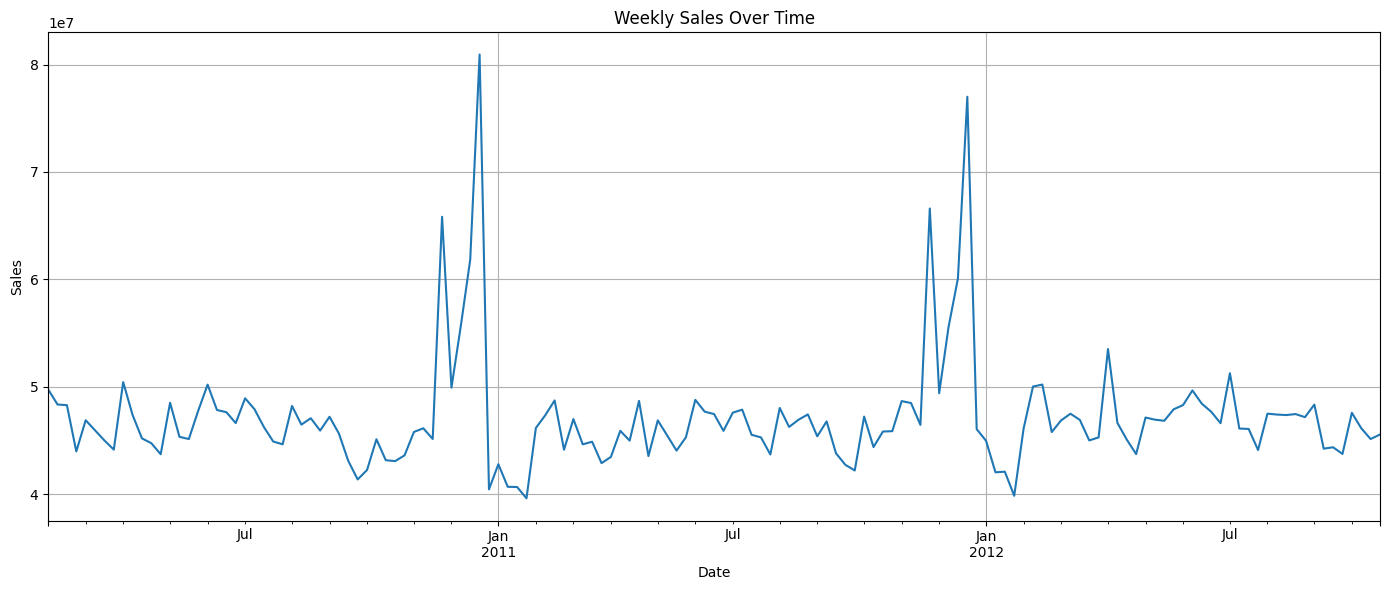

In [45]:
# 1. Sales trend over time
plt.figure(figsize=(14, 6))
df.groupby("Date")["Weekly_Sales"].sum().plot()
plt.title("Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

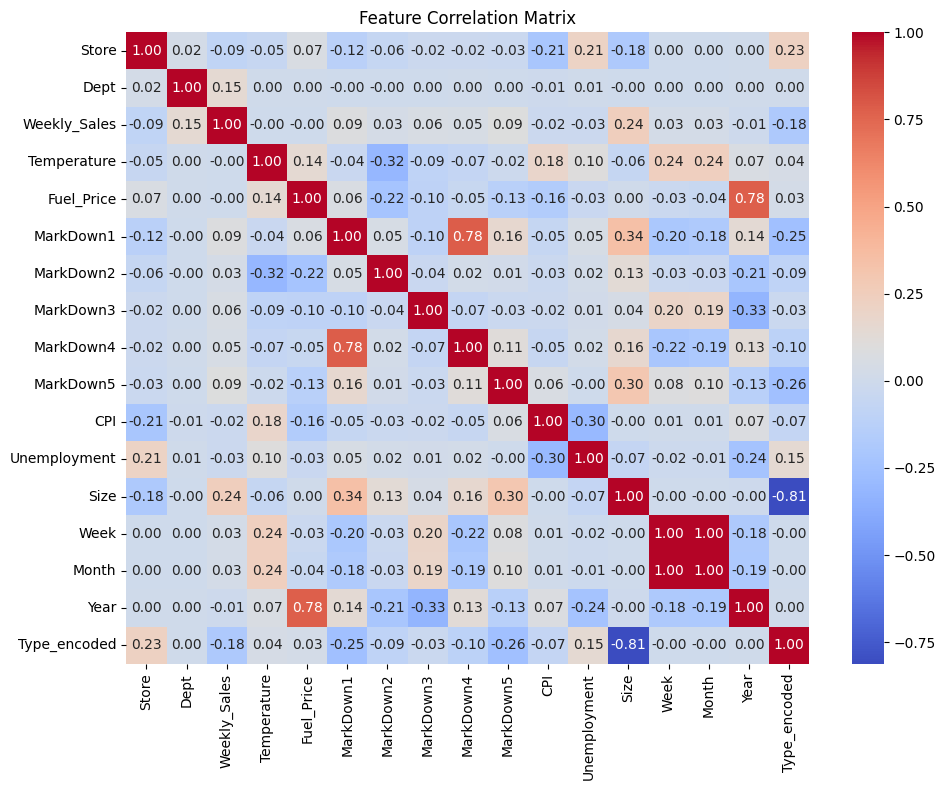

In [44]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

##Regression Modeling

In [12]:
features_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
df_model = df.dropna(subset=features_cols + ['Weekly_Sales'])  # ensure no NA

X = df_model[features_cols]
y = df_model['Weekly_Sales']

In [13]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##Evaluation

In [15]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.4f}')

MAE: 14547.00
RMSE: 21228.98
R² Score: 0.0644


##Plot actual vs predicted

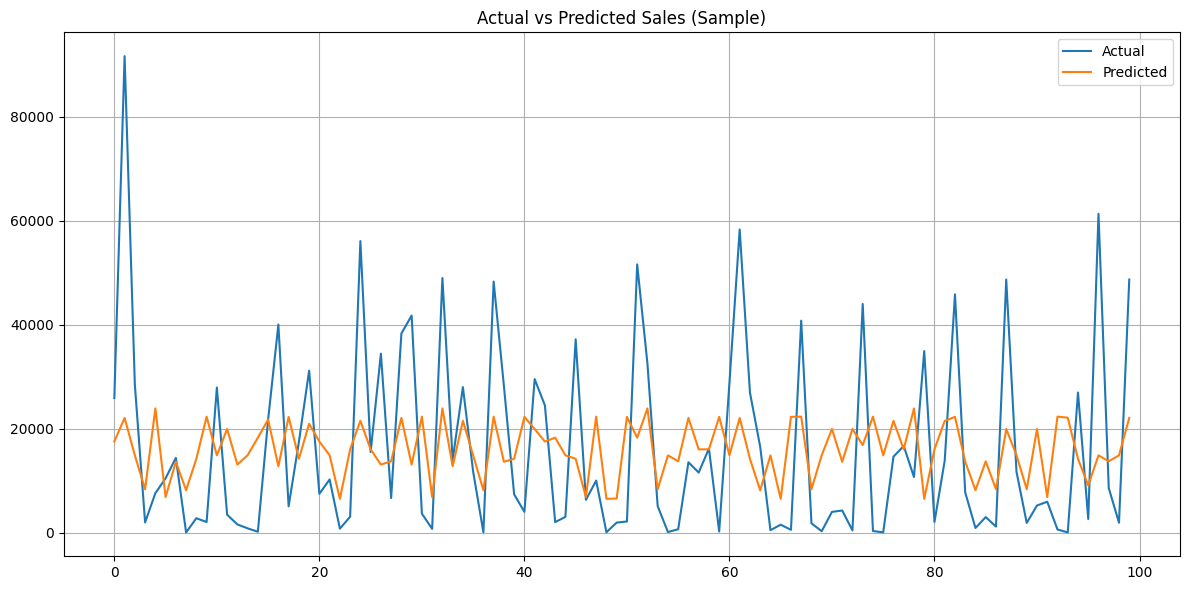

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Sales (Sample)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()